<a href="https://colab.research.google.com/github/neil-kuldip/Disproportion_of_NYC_Litter_Sanitation/blob/main/Disproportion_of_NYC_Litter_Sanitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Disproportion of NYC Litter Sanitation
######This project aims to address the negative association between perceived excessive littering and lower-income districts in New York City. 

In [174]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import pandasql as psql
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

##Combining Zip Code Database with Associated Polygons

######Loading zip code database

In [25]:
df = pd.read_csv("zip_code_database.csv")

In [ ]:
nyc_counties = ["Richmond County", "Kings County", "Queens County", 
                "Bronx County", "New York County"]
col_filt = ["zip", "county", "state", "longitude", "latitude"]
zip_code_boolean = df.county.isin(nyc_counties)
state_boolean = df.state.isin(["NY"])
df = df[zip_code_boolean] 
df = df[state_boolean]
zip_df = df[col_filt]
zip_df = zip_df.reset_index(drop=True)
df

######Getting geodataframes for merging zip code with associated polygon data

In [ ]:
zip_gdf = gpd.GeoDataFrame(zip_df)
ZCTA = gpd.read_file("Census_ZCTA5/Census_ZCTA5.shp")
ZCTA

######ZCTA --> Zip Code Tabulation Areas
######Filtering the large ZCTA dataset to NYC ZCTAs and having one main geodataframe

In [ ]:
ZCTA["ZCTA5CE20"] = ZCTA["ZCTA5CE20"].astype(int)
ZCTA = ZCTA[ZCTA["ZCTA5CE20"] < 11700]

ZCTA = ZCTA.rename({"ZCTA5CE20" : "zip"}, axis=1)
ZCTA = ZCTA[["zip", "geometry"]]
ZCTA_zip_gdf = pd.merge(zip_gdf, ZCTA, how="inner", on="zip")
ZCTA_zip_gdf = ZCTA_zip_gdf.reset_index(drop=True)
ZCTA_zip_gdf

##Filtering ACS(5-Year) Data for Median Income by Zip Code

#####Loading Median Income Data (ACS(5-Year))

In [108]:
acs_df = pd.read_csv("ACS(5-Year)_2019/ACS(5-Year)_2019.csv")

######Format df columns to be the description of the columns (first row)

In [109]:
header_row = 0
acs_df.columns = acs_df.iloc[header_row]
acs_df = acs_df.drop(header_row)
acs_df = acs_df.reset_index(drop=True)

######Filtering column names for:
- zipcode, 
- household median income, 
- family median income,
- married-couple median income, and 
- non-family median income

In [110]:
relevant_col = ["Geographic Area Name"]
relevant_col += [x for x in acs_df.columns if (("Median income" in x) and ("Estimate" in x))]
relevant_col

['Geographic Area Name',
 'Estimate!!Households!!Median income (dollars)',
 'Estimate!!Families!!Median income (dollars)',
 'Estimate!!Married-couple families!!Median income (dollars)',
 'Estimate!!Nonfamily households!!Median income (dollars)']

#####List of nyc_zipcodes to filter df

In [111]:
nyc_zip_codes = list(zip_df.zip)
nyc_zip_codes = [str(x) for x in nyc_zip_codes]

#####Cleaning NA data with zeros for average function

In [112]:
median_income_df = acs_df[relevant_col].replace("-", "0")


#####Returns just the zip_code in the column cell
#####Ex: ZCTA5 10001 -> 10001

In [113]:
def onlyZip(string):
    zip_code = string[6:]
    if (len(zip_code) == 4):
        zip_code = "0" + str(zip_code)
    return zip_code

#####Clean zip_code column and filters for only nyc zip codes 

In [114]:
new_cols = ["zip_code", "household", "family", "married_couple", "non-family"]
median_income_df.columns = new_cols

median_income_df["zip_code"] = median_income_df["zip_code"].apply(onlyZip)
zip_code_boolean = median_income_df["zip_code"].isin(nyc_zip_codes)
median_income_df = median_income_df[zip_code_boolean]
median_income_df = median_income_df.reset_index(drop=True)

#####Create income range categorical data based off the average of each median income
#####Data contains $250,000+ as values in some of the columns

In [ ]:
median_average = []
median_average_numeric = []
for x in median_income_df.index:
    high_income = r'250,000\+'
    temp = " ".join(list(median_income_df.iloc[x]))
    if (re.search(high_income, temp)):
        median_average.append("$200,000+")
        median_average_numeric.append(11)
    else:
        household = int(median_income_df.loc[x, "household"])
        family = int(median_income_df.loc[x, "family"])
        married_couple = int(median_income_df.loc[x, "married_couple"])
        non_family = int(median_income_df.loc[x, "non-family"])
        average = (household + family + married_couple + non_family)/4
        if (average == 0):
            median_average.append("N/A")
            median_average_numeric.append(0)
        elif (average < 20000):
            median_average.append("$1-19,999")
            median_average_numeric.append(1)
        elif (average < 40000):
            median_average.append("$20,000-39,999")
            median_average_numeric.append(2)
        elif (average < 60000):
            median_average.append("$40,000-59,999")
            median_average_numeric.append(3)
        elif (average < 80000):
            median_average.append("$60,000-79,999")
            median_average_numeric.append(4)
        elif (average < 100000):
            median_average.append("$80,000-99,999")
            median_average_numeric.append(5)
        elif (average < 120000):
            median_average.append("$100,000-119,999")
            median_average_numeric.append(6)
        elif (average < 140000):
            median_average.append("$120,000-139,999")
            median_average_numeric.append(7)
        elif (average < 160000):
            median_average.append("$140,000-159,999")
            median_average_numeric.append(8)
        elif (average < 180000):
            median_average.append("$160,000-179,999")
            median_average_numeric.append(9)
        elif (average < 200000):
            median_average.append("$180,000-199,999")
            median_average_numeric.append(10)
        else:
            median_average.append("$200,000+")
            median_average_numeric.append(11)

median_income_df = median_income_df.assign(median_income_average = median_average, 
                                           median_income_average_numeric = median_average_numeric)
median_income_df

#####Using pandasql queries to merge zip code df and income df 

In [ ]:
query = """
SELECT *
FROM median_income_df as M
INNER JOIN zip_df as Z
ON M.zip_code = Z.zip
""" 
zip_income_df = psql.sqldf(query)        
zip_income_df = zip_income_df.drop(["household", "family", "married_couple", "non-family", "zip", "state"], axis=1)
zip_income_df

######Using pandas merge to obtain geodataframe version of zip_income.df

In [122]:
median_income_gdf = gpd.GeoDataFrame(median_income_df)
median_income_gdf = median_income_gdf.rename({"zip_code" : "zip"}, axis=1)
median_income_gdf["zip"] = median_income_gdf["zip"].astype(int)
ZCTA_income_gdf = pd.merge(ZCTA_zip_gdf, median_income_gdf, how="left", on="zip")
ZCTA_income_gdf = ZCTA_income_gdf.drop(["household", "family", "married_couple", "non-family", "state"], axis=1)
ZCTA_income_gdf

,zip,county,longitude,latitude,geometry,median_income_average,median_income_average_numeric
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",6.0
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",2.0
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",8.0
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",10.0
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",11.0
...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",3.0
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",3.0
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",4.0
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",5.0


##Calculating Public Litter Basket & Public Food Waste Drop Off Site Density by Zip Code

In [134]:
litter_basket_gdf = gpd.read_file("DSNY_Litter_Basket_Inventory/litter_basket_inventory.shp")
dsny_districts_gdf = gpd.read_file("DSNY_Districts/dsny_districts.shp")
food_scraps_gdf = gpd.read_file("Food_Scrap_Drop-Off_Locations_in_NYC/food_scrap_drop_off_locations.shp")

In [140]:
def getDistrictZip(district):
    """
    function that returns a list of zip codes whose polgyons overlap with the given DNSY district's polygon to
    determine which zip codes are a part of the DSNY district

    Parameters
    ----------
    district : shapely.geometry.polygon.Polygon
        DSNY district as shapely polygon object

    Returns
    -------
    list of string values
        Zip codes that overlap (are a part of) the given district
    str
        N/A if no overlap is found
    """
    result = []
    for x in ZCTA_income_gdf.index:
        if district.overlaps(ZCTA_income_gdf.loc[x, "geometry"]):
            result.append(ZCTA_income_gdf.loc[x, "zip"])
    if len(result) == 0:
        return "N/A"
    else:
        return result

In [138]:
def getZip(basket):
    """
    function that returns the zip code in the location of the given litter basket by checking
    if the point is within the zipcode polygon

    Parameters
    ----------
    basket : shapely.geometry.point.Point
        NYC public litter basket as shapely polygon object

    Returns
    -------
    str
       name of Zip code in the location of the litter basket, N/A if not found 

    """
    for x in ZCTA_income_gdf.index:
        if basket.within(ZCTA_income_gdf.loc[x, "geometry"]):
            return(ZCTA_income_gdf.loc[x, "zip"])
    return "N/A"     

#####Using the functions to retrieve zip codes for districts, baskets, and food scrap sites

In [141]:
dsny_districts_gdf["zipcode"] = dsny_districts_gdf["geometry"].apply(getDistrictZip)
litter_basket_gdf["zipcode"] = litter_basket_gdf["geometry"].apply(getZip)
food_scraps_gdf["zipcode"] = food_scraps_gdf["geometry"].apply(getZip)

#####Aggregating geodataframe to count number of baskets per zip code

In [144]:
grouped_basket_gdf = litter_basket_gdf.assign()
grouped_basket_gdf = grouped_basket_gdf.groupby("zipcode").count()
grouped_basket_gdf = grouped_basket_gdf.reset_index()
grouped_basket_gdf = grouped_basket_gdf.rename({"basketid" : "num_baskets", "zipcode": "zip"}, axis=1)
grouped_basket_gdf = grouped_basket_gdf[["zip", "num_baskets"]]
grouped_basket_gdf

,zip,num_baskets
0,10001,307
1,10002,280
2,10003,410
3,10004,61
4,10005,41
...,...,...
197,11691,73
198,11692,32
199,11693,57
200,11694,99


#####Sub geodataframe of the main one comparing zip code to income and litter baskets

In [ ]:
zipcode_income_basket_gdf = pd.merge(ZCTA_income_gdf, grouped_basket_gdf, how="left", on="zip")
zipcode_income_basket_gdf

#####Aggregating geodataframe to count number of food scrap sites per zip code

In [148]:
grouped_scraps_gdf = food_scraps_gdf.assign()
grouped_scraps_gdf = grouped_scraps_gdf.groupby("zipcode").count()
grouped_scraps_gdf = grouped_scraps_gdf.reset_index()
grouped_scraps_gdf = grouped_scraps_gdf.rename({"object_id" : "num_sites", "zipcode": "zip"}, axis=1)
grouped_scraps_gdf = grouped_scraps_gdf[["zip", "num_sites"]]
grouped_scraps_gdf

,zip,num_sites
0,10001,2
1,10002,2
2,10003,2
3,10004,5
4,10009,3
...,...,...
87,11432,1
88,11434,1
89,11435,2
90,11691,1


#####Main geodataframe for comparing income to:
- Number of publicly available litter baskets
- Number of publicly available food waste drop off sites
- Averge median income 

In [151]:
zipcode_income_basket_scrap_gdf = pd.merge(zipcode_income_basket_gdf, grouped_scraps_gdf, how="left", on="zip")
zipcode_income_basket_scrap_gdf


,zip,county,longitude,latitude,geometry,median_income_average,median_income_average_numeric,num_baskets,num_sites
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",6.0,307.0,2.0
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",2.0,280.0,2.0
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",8.0,410.0,2.0
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",10.0,61.0,5.0
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",11.0,41.0,NaN
...,...,...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",3.0,73.0,1.0
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",3.0,32.0,NaN
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",4.0,57.0,NaN
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",5.0,99.0,NaN


##Spatial Data Map Creation

In [153]:
def getXCoord(point):
    """
    function that returns the x coordinate of a point object passed in as a string

    Parameters
    ----------
    point : string of Point class object
        Ex: "POINT (-73.79488819299996 40.79252126700004)"

    Returns
    -------
    string of x coordinate (Longitude)
        Ex return: "-73.79488819299996"

    """
    coord = point
    coord = coord.split(" ")
    x_coord = coord[1][1:]
    return float(x_coord)

In [154]:
def getYCoord(point):
    """
    function that returns the y coordinate of a point object passed in as a string

    Parameters
    ----------
    point : string of Point class object
        Ex: "POINT (-73.79488819299996 40.79252126700004)"

    Returns
    -------
    string of y coordinate (Latitude)
        Ex return: "40.79252126700004"

    """
    coord = point
    coord = coord.split(" ")
    y_coord = coord[2][:-1]
    return float(y_coord)

######Creation of analysis_map to compare features, centered on NYC

In [181]:
analysis_map = folium.Map(
    location=[40.730610, -73.935242],
    tiles='cartodbpositron',
    zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(analysis_map)
analysis_map

#####Note: Seems easier to create MarkerCluster class with locations from .csv file than .shp
#####Start of cleaning, filtering, and extracting location data of public litter baskets

In [182]:
litter_baskets = pd.read_csv("DSNY_Litter_Basket_Inventory/DSNY_Litter_Basket_Inventory.csv")
basket_gdf = gpd.GeoDataFrame(litter_baskets[["SECTION", "BASKETTYPE", "point"]])

#####Applying functions to get the coordinates

In [183]:
basket_gdf["Long"] = basket_gdf["point"].apply(getXCoord)
basket_gdf["Lat"] = basket_gdf["point"].apply(getYCoord)
basket_gdf

,SECTION,BASKETTYPE,point,Long,Lat
0,QE078,H,POINT (-73.79488819299996 40.79252126700004),-73.794888,40.792521
1,QE083,R,POINT (-73.81949439499994 40.73456626300003),-73.819494,40.734566
2,BX071,H,POINT (-73.90348256799996 40.86820017500003),-73.903483,40.868200
3,MN061,S,POINT (-73.98010683599995 40.73861667800003),-73.980107,40.738617
4,BX121,S,POINT (-73.86738843799998 40.87125820800003),-73.867388,40.871258
...,...,...,...,...,...
23214,BX062,S,POINT (-73.88557818999993 40.84449742900006),-73.885578,40.844497
23215,MN081,S,POINT (-73.96802895699994 40.76855951300007),-73.968029,40.768560
23216,BX071,H,POINT (-73.90158499599995 40.86254218400006),-73.901585,40.862542
23217,BKN014,S,POINT (-73.96118728899995 40.70850006200004),-73.961187,40.708500


#####Adding each location as a marker in the marker cluster
#####Creating a layer over the map that can be controlled through layer controls
#####Using trash icon from font-awesome and making popups that show the litter basket's
#####DSNY sanitation section

In [184]:
basket_locations = list(zip(basket_gdf.Lat, basket_gdf.Long))
basket_icons = [folium.Icon(icon="trash", prefix="fa") for _ in range(len(basket_locations))]
basket_labels = [folium.Popup(str("Litter Basket - DSNY District: " + x[:-1] + ", Section: " + x[-1:]), max_width=300) for x in basket_gdf.SECTION]
basket_cluster = MarkerCluster(locations=basket_locations, icons=basket_icons, popups=basket_labels, name="Public Litter Baskets")
analysis_map.add_child(basket_cluster)
analysis_map

#####End of public litter basket data usage


#####Start of cleaning, filtering, and extracting location data of public food scrap drop-off sites

In [163]:
food_scrap_df = pd.read_csv("Food_Scrap_Drop-Off_Locations_in_NYC/Food_Scrap_Drop-Off_Locations_in_NYC.csv")
scrap_gdf = gpd.GeoDataFrame(food_scrap_df[["Borough", "Food_Scrap_Drop_Off_Site_Name", "Longitude", "Latitude", "Operation_Day_Hours",
                                         "Open_Months"]])
scrap_locations = list(zip(scrap_gdf.Latitude, scrap_gdf.Longitude))
scrap_icons = [folium.Icon(color="green", icon="recycle", prefix="fa") for _ in range(len(scrap_locations))]
 
scrap_labels = [folium.Popup("Borough: " + x + " - " + "Name: " + y + " - " + "Operation Hours: " + z + " - " + "Open Months: " + a, 
                             max_width=300) for x,y,z,a in list(zip(scrap_gdf["Borough"], scrap_gdf["Food_Scrap_Drop_Off_Site_Name"],
                                                                                   scrap_gdf["Operation_Day_Hours"], scrap_gdf["Open_Months"]))]
scrap_cluster = MarkerCluster(locations=scrap_locations, icons=scrap_icons, popups=scrap_labels, name="Public Food Scrap Drop Off Sites")
analysis_map.add_child(scrap_cluster)

#####End of public food scrap site data usage


#####Start of taking DSNY Districts shapefile and converting to GeoJson to plot into analysis map

In [164]:
dsny_districts = gpd.read_file("DSNY_Districts/dsny_districts.shp")
district_json = dsny_districts.to_json()
geo_json = folium.GeoJson(data=district_json, name="DSNY Districts",
                          style_function=lambda x: {'fillColor': 'green'}, show=False)
geo_json.add_to(analysis_map)

#####End of DSNY district data usage


#####Start of taking the zipcode & income geodataframe and converting to GeoJson to plot into analysis map

In [167]:
zip_json = ZCTA_income_gdf.to_json()
zip_geo_json = folium.GeoJson(data=zip_json, name="Zip Code Tabulation Areas (ZCTA)",
                                 style_function=lambda x: {'fillColor': 'orange'})
zip_geo_json.add_to(analysis_map)

#####End of Zip Code Tabulation Areas data usage
#####Added layer control to toggle info on map on/off

In [173]:
folium.LayerControl(collapsed=False).add_to(analysis_map)
analysis_map.save("analysis_map.html")
analysis_map

##Vizualizing Data
- Zip code to income
- Zip code to public litter baskets
- Zip code to food scrap sites

In [176]:
gdf = zipcode_income_basket_scrap_gdf
gdf = gdf.rename({"zip" : "zip_code"}, axis=1)
gdf["median_income_average"].replace({"N/A" : np.nan}, inplace=True)
gdf = gdf.dropna(subset=["median_income_average", "num_sites"])

In [177]:
highest_basket_gdf = gdf.sort_values("num_baskets", ascending=False)[:20]
highest_basket_gdf = highest_basket_gdf.reset_index(drop=True)
highest_basket_gdf["zip_code"] = highest_basket_gdf["zip_code"].astype(str)

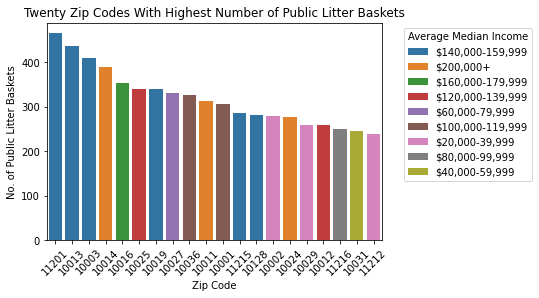

In [179]:
ax = sns.barplot(x="zip_code", y="num_baskets", hue="median_income_average", 
                 dodge=False, data=highest_basket_gdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set(xlabel="Zip Code", ylabel="No. of Public Litter Baskets", title="Twenty Zip Codes With Highest Number of Public Litter Baskets")
ax.legend(title="Average Median Income", bbox_to_anchor=(1.05, 1))
plt.savefig("Twenty_Highest_Num_of_Baskets.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
plt.clf()

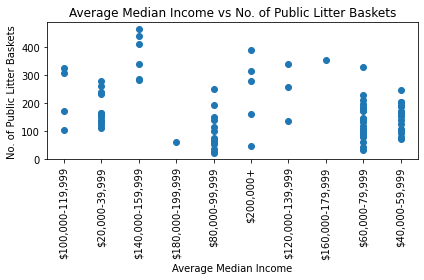

In [180]:
x_values = gdf["median_income_average"]
y_values = gdf["num_baskets"]

ax2 = plt.scatter(x_values, y_values)

plt.xlabel("Average Median Income")
plt.ylabel("No. of Public Litter Baskets")
plt.title("Average Median Income vs No. of Public Litter Baskets")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Average_Median_Income_vs_Baskets.png", bbox_inches='tight', dpi=300)